### Gaussian YOLOv3

This is a demo to assess integration of Gaussian YOLOv3 with our framework.
The original code is found at https://github.com/motokimura/PyTorch_Gaussian_YOLOv3.

In [1]:
import sys
sys.path.insert(0, "/home/atimans/Desktop/project_1/conformalbb")

In [2]:
import sys
import argparse
import yaml
import os
import importlib

import cv2
import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

/home/atimans/mambaforge/envs/conf1m/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
from gaussian_yolo.yolov3 import *
import gaussian_yolo.utils as yolo_utils
from gaussian_yolo.vis_bbox import vis_bbox

In [9]:
# Choose config file for this demo
cfg_path = 'conformalbb/gaussian_yolo/gaussian_yolov3_eval.cfg'

# Specify checkpoint file which contains the weight of the model you want to use
ckpt_path = 'checkpoints/gaussian_yolov3_coco.pth'

# Detection threshold
detect_thresh = 0.3

# Use CPU if gpu < 0 else use GPU
gpu = -1

In [7]:
image_path = "../../../../media/atimans/hdd/datasets/coco/val2017/000000005037.jpg"

In [10]:
# Load configratio parameters for this demo
with open(cfg_path, 'r') as f:
    cfg = yaml.safe_load(f)

model_config = cfg['MODEL']
imgsize = cfg['TEST']['IMGSIZE']
confthre = cfg['TEST']['CONFTHRE'] 
nmsthre = cfg['TEST']['NMSTHRE']
gaussian = cfg['MODEL']['GAUSSIAN']

# if detect_thresh is not specified, the parameter defined in config file is used
if detect_thresh:
    confthre = detect_thresh

In [11]:
# Load model
model = YOLOv3(model_config)

# Load weight from the checkpoint
print("loading checkpoint %s" % (ckpt_path))
state = torch.load(ckpt_path)

if 'model_state_dict' in state.keys():
    model.load_state_dict(state['model_state_dict'])
else:
    model.load_state_dict(state)

model.eval()

if gpu >= 0:
    # Send model to GPU
    model.cuda()

Gaussian YOLOv3
Gaussian YOLOv3
Gaussian YOLOv3
loading checkpoint checkpoints/gaussian_yolov3_coco.pth


In [37]:
# Load image
img = cv2.imread(image_path)

# Preprocess image
img_raw = img.copy()[:, :, ::-1].transpose((2, 0, 1))
img, info_img = yolo_utils.preprocess(img, imgsize, jitter=0)  # info = (h, w, nh, nw, dx, dy)
img = np.transpose(img / 255., (2, 0, 1))
img = torch.from_numpy(img).float().unsqueeze(0)

if gpu >= 0:
    # Send model to GPU
    img = Variable(img.type(torch.cuda.FloatTensor))
else:
    img = Variable(img.type(torch.FloatTensor))

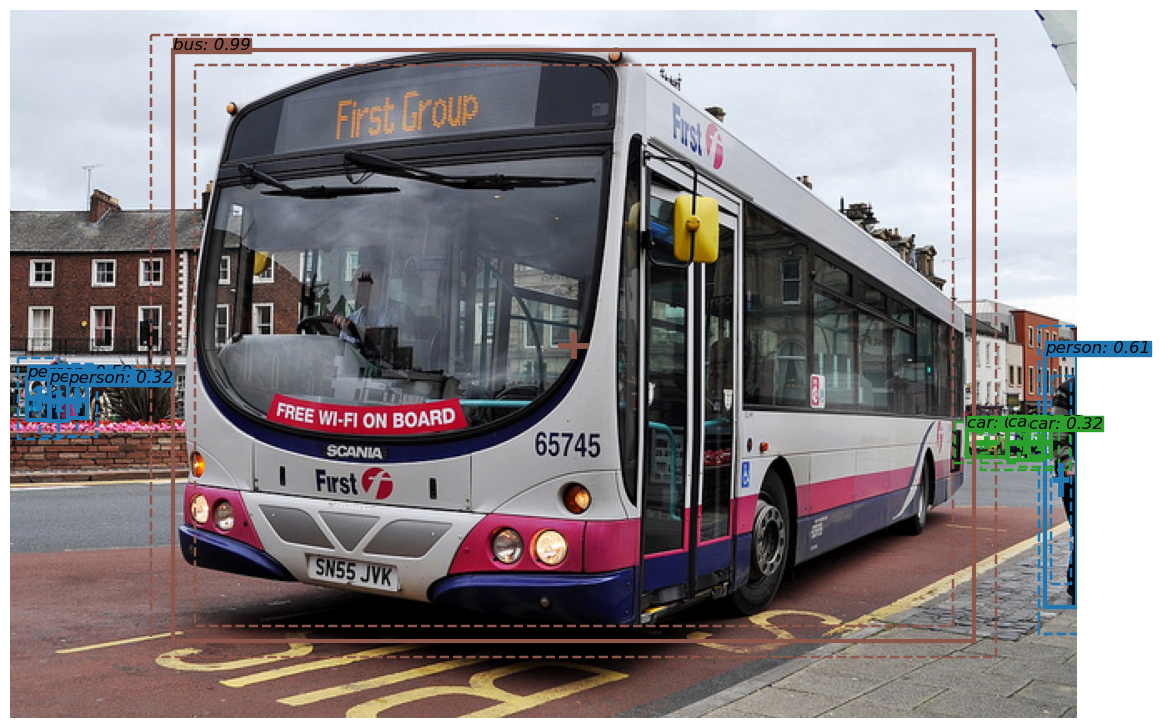

In [38]:
# Inference
with torch.no_grad():
    outputs = model(img)
    outputs = yolo_utils.postprocess(outputs, 80, confthre, nmsthre)

if outputs[0] is None:
    print("No Objects Detected!!")
    # sys.exit(0)

# Visualize detected bboxes
coco_class_names, coco_class_ids, coco_class_colors = yolo_utils.get_coco_label_names()

bboxes = list()
classes = list()
scores = list()
colors = list()
sigmas = list()

for output in outputs[0]:
    x1, y1, x2, y2, conf, cls_conf, cls_pred = output[:7]
    if gaussian:
        sigma_x, sigma_y, sigma_w, sigma_h = output[7:]
        sigmas.append([sigma_x, sigma_y, sigma_w, sigma_h])

    cls_id = coco_class_ids[int(cls_pred)]
    box = yolo_utils.yolobox2label([y1, x1, y2, x2], info_img)
    bboxes.append(box)
    classes.append(cls_id)
    scores.append(cls_conf * conf)
    colors.append(coco_class_colors[int(cls_pred)])
    
    # image size scale used for sigma visualization
    h, w, nh, nw, _, _ = info_img
    sigma_scale_img = (w / nw, h / nh)
    
fig, ax = vis_bbox(
    img_raw, bboxes, label=classes, score=scores, label_names=coco_class_names, sigma=sigmas, 
    sigma_scale_img=sigma_scale_img,
    sigma_scale_xy=2., sigma_scale_wh=1.64,  # 2-sigma
    show_inner_bound=True,  # do not show inner rectangle for simplicity
    instance_colors=colors, linewidth=3)

# fig.savefig('demo.png')

In [15]:
torch.set_printoptions(sci_mode=False)

In [39]:
outputs[0]

tensor([[  403.5028,   203.3585,   415.7482,   302.6014,     0.6131,     0.9994,
             0.0000,     3.0734,     8.3447,     1.1667,     1.0815],
        [    6.4568,   212.7828,    15.1320,   229.5666,     0.6124,     0.9595,
             0.0000,     6.3612,     5.8019,     1.3167,     1.3149],
        [   14.7556,   214.5203,    22.4592,   229.8733,     0.5340,     0.9853,
             0.0000,     6.7860,     4.7338,     1.3207,     1.2827],
        [   22.3810,   215.1166,    29.5863,   228.8036,     0.3199,     0.9888,
             0.0000,     4.9664,     5.5383,     1.3910,     1.3854],
        [  372.7146,   232.6885,   388.4079,   244.1644,     0.8978,     0.9978,
             2.0000,     4.5673,     2.1409,     1.2076,     1.1439],
        [  388.9364,   232.0937,   402.5067,   245.2565,     0.5554,     0.9565,
             2.0000,     7.2260,     3.0753,     1.5250,     1.2135],
        [  396.9676,   232.7528,   405.6051,   244.0064,     0.3174,     0.9954,
             

In [17]:
print("BUS:")
print("(x1, y1, x2, y2, obj_conf, cls_conf, cls_pred, sigma_x, sigma_y, sigma_w, sigma_h)")
outputs[0][-1]

BUS:
(x1, y1, x2, y2, obj_conf, cls_conf, cls_pred, sigma_x, sigma_y, sigma_w, sigma_h)


tensor([ 63.2590,  85.4099, 375.6570, 315.6901,   0.9966,   0.9972,   5.0000,
          7.4677,   6.3050,   1.0219,   1.0207])

In [18]:
print("Get into same shape (rescaled xy coordinates to original image size):")
print("Replace sigma_h, sigma_w with sigma_y, sigma_x for box coord format")
(bboxes[-1][1], bboxes[-1][0], bboxes[-1][3], bboxes[-1][2], 
 outputs[0][-1][4], outputs[0][-1][5], int(outputs[0][-1][6]),
 sigmas[-1][0], sigmas[-1][1], sigmas[-1][0], sigmas[-1][1])

Get into same shape (rescaled xy coordinates to original image size):
Replace sigma_h, sigma_w with sigma_y, sigma_x for box coord format


(tensor(97.3215),
 tensor(23.7290),
 tensor(577.9338),
 tensor(378.3272),
 tensor(0.9966),
 tensor(0.9972),
 5,
 tensor(7.4677),
 tensor(6.3050),
 tensor(7.4677),
 tensor(6.3050))